![](https://storage.googleapis.com/mle-courses-prod/users/61b6fa1ba83a7e37c8309756/private-files/bf4518b0-5a1e-11ef-9b72-9db6eacc12d1-RAGGraph___Neo4J___CamelAI__8_.png)

In [ ]:
!gdown 1GLU5dYPZcSxBZxP5IoC3FpCYhNkLvhfP

Downloading...
From: https://drive.google.com/uc?id=1GLU5dYPZcSxBZxP5IoC3FpCYhNkLvhfP
To: /content/eng-vie.txt
100% 1.55M/1.55M [00:00<00:00, 181MB/s]


### I. Chuẩn bị dữ liệu

In [ ]:
!mkdir /content/data/
!mv /content/eng-vie.txt /content/data/eng-vie.txt

Các mẫu sẽ như sau:

```
Tiếng Việt: Tôi ghét ti vi.
Tiếng Anh: I hate TV.
```


```
Tiếng Việt: Bạn đã lên lầu rồi à?
Tiếng Anh: Did you go upstairs?
```


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    return s


In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]
    print(pairs[0])

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'vie', False)
print(random.choice(pairs))

Reading lines...
['run !', 'chạy !']
Read 9428 sentence pairs
Counted words:
eng 4414
vie 2765
["i'm sorry i forgot to wake you up .", 'tôi xin lỗi tôi đã quên đánh thức bạn .']


In [ ]:
input_lang.name

'eng'

In [ ]:
output_lang.name

'vie'

In [ ]:
pairs[2]

['help !', 'giúp tôi với !']

#### In một số mẫu dịch

In [ ]:
print(random.choice(pairs))

["he didn't come to the last meeting .", 'anh ta đã không đếm bữa tiệc cuối .']


In [ ]:
print(random.choice(pairs))

["i've been having a lot of back pain .", 'dạo này hay bị đau lưng dã man .']


In [ ]:
print(random.choice(pairs))

['what kind of fish is that ?', 'đó là loại cá gì ?']


In [ ]:
print(random.choice(pairs))

['do you play soccer ?', 'bạn có chơi bóng đá không ?']


### II. Kiến trúc Encoder

![](https://storage.googleapis.com/mle-courses-prod/users/61b6fa1ba83a7e37c8309756/private-files/57ff2310-5a1b-11ef-9b72-9db6eacc12d1-Screen_Shot_2024_08_14_at_15.58.10.png)

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### III. Kiến trúc Decoder với Attention

![](https://storage.googleapis.com/mle-courses-prod/users/61b6fa1ba83a7e37c8309756/private-files/9e8c1ec0-5a19-11ef-9b72-9db6eacc12d1-Screen_Shot_2024_08_14_at_15.45.47.png)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MatmulAttention(nn.Module):
    def __init__(self):
        super(MatmulAttention, self).__init__()

    def forward(self, query, keys):
        # query: Tensor of shape (batch_size, 1, hidden_dim)
        # keys: Tensor of shape (batch_size, seq_len, hidden_dim)

        # Calculate attention scores by performing matrix multiplication between query and keys
        # scores: Tensor of shape (batch_size, 1, seq_len)
        scores = torch.bmm(query, keys.transpose(1, 2))

        # Apply softmax to get the attention weights
        # weights: Tensor of shape (batch_size, 1, seq_len)
        weights = F.softmax(scores, dim=-1)

        # Calculate the context vector as a weighted sum of the keys
        # context: Tensor of shape (batch_size, 1, hidden_dim)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = MatmulAttention()  # No need to pass hidden_size here
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # encoder_outputs: Tensor of shape (batch_size, seq_len, hidden_size)
        # encoder_hidden: Tensor of shape (1, batch_size, hidden_size)
        batch_size = encoder_outputs.size(0)
        # decoder_input: Tensor of shape (batch_size, 1), initialized with SOS_token
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        # decoder_hidden: Tensor of shape (1, batch_size, hidden_size), initialized with encoder_hidden
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:

                # Teacher forcing: Feed the target as the next input
                # target_tensor[:, i].unsqueeze(1): Tensor of shape (batch_size, 1)
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                # topi.squeeze(-1): Tensor of shape (batch_size, 1)
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        # decoder_outputs: Tensor of shape (batch_size, MAX_LENGTH, output_size)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        # attentions: Tensor of shape (batch_size, MAX_LENGTH, seq_len)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        # input: Tensor of shape (batch_size, 1)
        # embedded: Tensor of shape (batch_size, 1, hidden_size)
        embedded = self.dropout(self.embedding(input))

        # query: Tensor of shape (batch_size, 1, hidden_size)
        query = hidden.permute(1, 0, 2)
        # context: Tensor of shape (batch_size, 1, hidden_size)
        # attn_weights: Tensor of shape (batch_size, 1, seq_len)
        context, attn_weights = self.attention(query, encoder_outputs)
        # input_gru: Tensor of shape (batch_size, 1, 2 * hidden_size)
        input_gru = torch.cat((embedded, context), dim=2)

        # output: Tensor of shape (batch_size, 1, hidden_size)
        # hidden: Tensor of shape (1, batch_size, hidden_size)
        output, hidden = self.gru(input_gru, hidden)
        # output: Tensor of shape (batch_size, 1, output_size)
        output = self.out(output)

        return output, hidden, attn_weights



In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'vie', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
hidden_size = 128
batch_size = 8
MAX_LENGTH = 64


input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 50, print_every=1, plot_every=1)

Reading lines...
['run !', 'chạy !']
Read 9428 sentence pairs
Counted words:
vie 2765
eng 4414
1m 28s (- 71m 59s) (1 2%) 0.6925
2m 51s (- 68m 45s) (2 4%) 0.5115
4m 16s (- 66m 58s) (3 6%) 0.4392
5m 40s (- 65m 15s) (4 8%) 0.3832
7m 4s (- 63m 37s) (5 10%) 0.3379
8m 27s (- 62m 1s) (6 12%) 0.2992
9m 50s (- 60m 26s) (7 14%) 0.2672
11m 13s (- 58m 56s) (8 16%) 0.2403
12m 37s (- 57m 30s) (9 18%) 0.2172
14m 2s (- 56m 8s) (10 20%) 0.1976
15m 25s (- 54m 41s) (11 22%) 0.1804
16m 50s (- 53m 18s) (12 24%) 0.1661
18m 15s (- 51m 57s) (13 26%) 0.1530
19m 40s (- 50m 35s) (14 28%) 0.1426
21m 5s (- 49m 11s) (15 30%) 0.1320
22m 28s (- 47m 45s) (16 32%) 0.1231
23m 52s (- 46m 21s) (17 34%) 0.1150
25m 17s (- 44m 57s) (18 36%) 0.1082
26m 41s (- 43m 32s) (19 38%) 0.1020
28m 4s (- 42m 7s) (20 40%) 0.0960
29m 29s (- 40m 43s) (21 42%) 0.0909
30m 53s (- 39m 18s) (22 44%) 0.0866
32m 18s (- 37m 55s) (23 46%) 0.0821
33m 43s (- 36m 31s) (24 48%) 0.0784
35m 9s (- 35m 9s) (25 50%) 0.0743
36m 33s (- 33m 44s) (26 52%) 0.070

In [ ]:
output_lang.word2index

{'run': 2,
 '!': 3,
 'help': 4,
 'jump': 5,
 'stop': 6,
 'wait': 7,
 'go': 8,
 'on': 9,
 '.': 10,
 'hello': 11,
 'hurry': 12,
 'i': 13,
 'try': 14,
 'cheers': 15,
 'eat': 16,
 'it': 17,
 'got': 18,
 'listen': 19,
 'really': 20,
 '?': 21,
 'thanks': 22,
 'goodbye': 23,
 'me': 24,
 'agree': 25,
 'perfect': 26,
 'we': 27,
 'know': 28,
 'you': 29,
 'cheer': 30,
 'up': 31,
 'he': 32,
 'tries': 33,
 'forgot': 34,
 "i'll": 35,
 "i'm": 36,
 'bald': 37,
 'busy': 38,
 'here': 39,
 'too': 40,
 'late': 41,
 'come': 42,
 'to': 43,
 'bed': 44,
 'fainted': 45,
 'hate': 46,
 'tv': 47,
 'laughed': 48,
 'will': 49,
 'is': 50,
 'bad': 51,
 "it's": 52,
 'cold': 53,
 'ours': 54,
 'keep': 55,
 'back': 56,
 'look': 57,
 'seriously': 58,
 'she': 59,
 'cried': 60,
 'sit': 61,
 'there': 62,
 'stay': 63,
 'home': 64,
 "what's": 65,
 'who': 66,
 'knows': 67,
 'are': 68,
 'ok': 69,
 'definitely': 70,
 'find': 71,
 'a': 72,
 'job': 73,
 'can': 74,
 'read': 75,
 'did': 76,
 'that': 77,
 'guess': 78,
 'so': 79,
 'lov

torch.Size([1, 64, 4])
input = tôi thích hát
output = like singing . <EOS>


<ipython-input-31-33388386ad9e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-31-33388386ad9e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


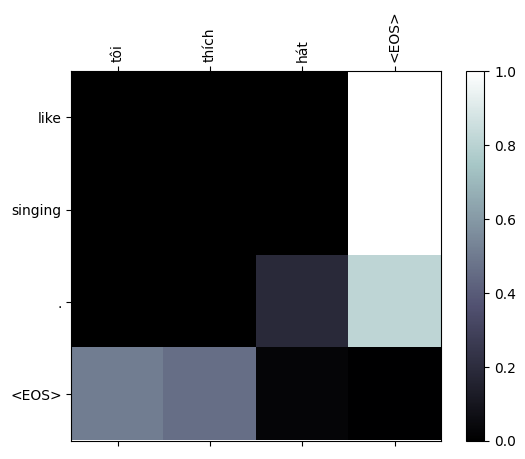

In [ ]:
%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print(attentions.shape)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('tôi thích hát')